In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
clean_data = pd.read_csv("data/cleanned_data.csv")
def plot_laps(data, y_col="BRAKE", distance_range=(0, 350),
              exclude_laps=None, only_valid=True,
              figsize=(12, 8), point_size=1):
    """
    Plot lap data with LAPDISTANCE on the x-axis and a chosen column on the y-axis.

    Parameters
    ----------
    data : pd.DataFrame
        The cleaned lap data.
    y_col : str, default="BRAKE"
        Column to plot against LAPDISTANCE.
    distance_range : tuple, default=(0, 300)
        (min_distance, max_distance) range for LAPDISTANCE.
    exclude_laps : list or set, optional
        Laps to exclude from plotting.
    only_valid : bool, default=True
        If True, filter out invalid laps.
    figsize : tuple, default=(12, 8)
        Figure size.
    point_size : int, default=1
        Scatter point size.
    """

    d = data.copy()

    # Filter invalid laps
    if only_valid:
        d = d[d["invalid_lap"] == 0]

    # Exclude laps
    if exclude_laps is not None:
        d = d[~d["lap_id"].isin(exclude_laps)]

    # Distance filter
    d = d[(d["LAPDISTANCE"] >= distance_range[0]) &
          (d["LAPDISTANCE"] <= distance_range[1])]

    # Plot
    plt.figure(figsize=figsize)
    plt.scatter(d["LAPDISTANCE"], d[y_col], s=point_size, c=d["lap_id"])
    plt.xlabel("LAPDISTANCE")
    plt.ylabel(y_col)
    plt.title(f"{y_col} vs LAPDISTANCE")
    # plt.colorbar(label="lap_id")
    plt.show()


In [3]:
d_full = clean_data[clean_data["invalid_lap"] == 0]
d_full = d_full.sort_values(by=["lap_id", "LAPDISTANCE"])
d_full["brake-diff"] = d_full["BRAKE"].diff()

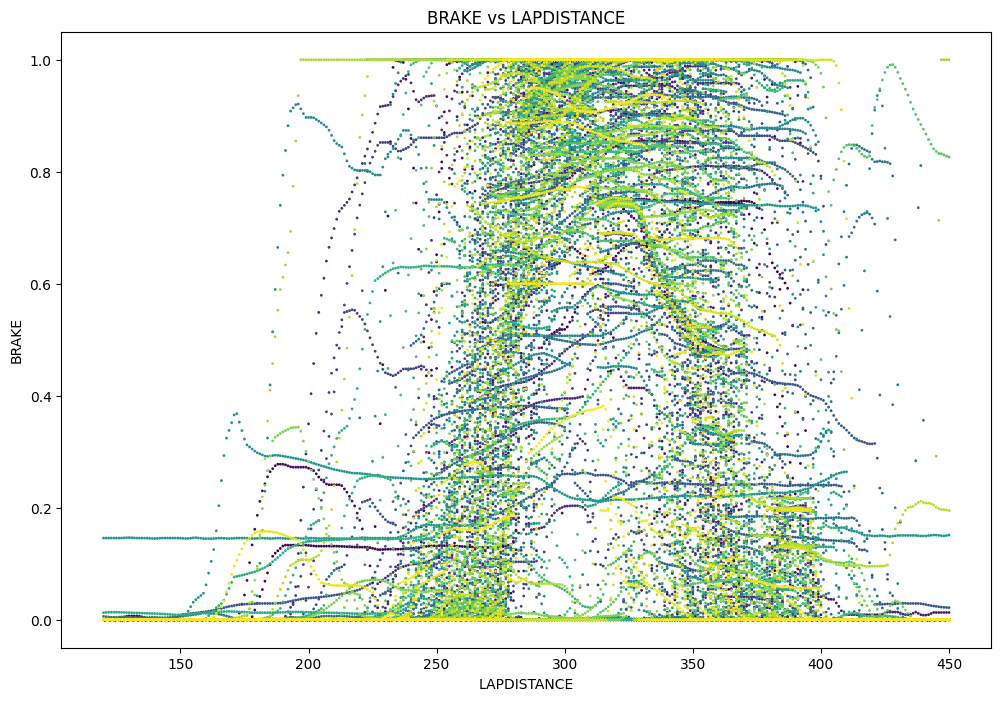

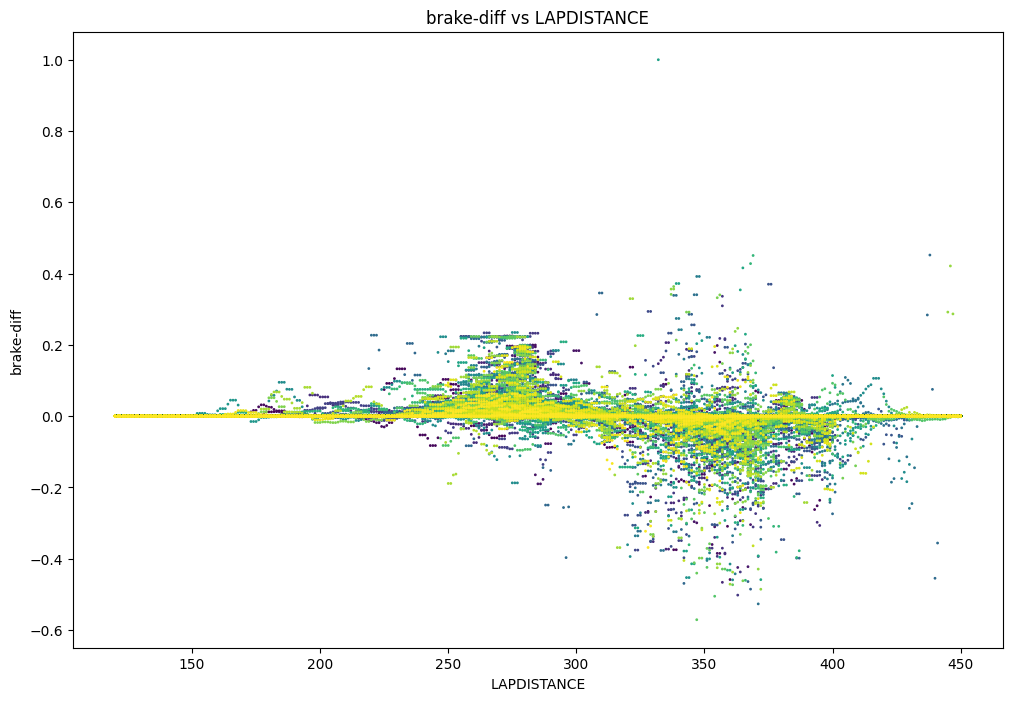

In [6]:
plot_laps(d_full, distance_range=(120, 450), figsize=(12, 8))
plot_laps(d_full, distance_range=(120, 450), y_col="brake-diff")

In [7]:
d = clean_data[(clean_data["LAPDISTANCE"] < 450) & (clean_data["invalid_lap"] == 0)]
d = d.sort_values(by=["lap_id", "LAPDISTANCE"])
d["brake-diff"] = d["BRAKE"].diff()

In [31]:
def get_braking_point(df):
    results =[]

    for lap_id, group in df.groupby("lap_id"):
        group = group.sort_values("LAPDISTANCE").reset_index(drop=True)

        if group["BRAKE"].isna().all():
            results.append({
            'lap_id': lap_id,
            'max_brake_LD': None,
            'BP_LD': None,
            'brake_decrease_LD': None,
            'brake_end_LD': None
            })
            continue

        max_idx = group["BRAKE"].idxmax()

        if pd.isna(max_idx) or max_idx not in group.index:
            results.append({
            'lap_id': lap_id,
            'max_brake_LD': None,
            'BP_LD': None,
            'brake_decrease_LD': None,
            'brake_end_LD': None
            })
            continue
        
        max_brake_LD = group.loc[max_idx, "LAPDISTANCE"]
            
        before_max = group.loc[:group.index.get_loc(max_idx)]
        zero_brake = before_max[before_max["BRAKE"] == 0]

        if not zero_brake.empty:
            bp_ld = zero_brake["LAPDISTANCE"].iloc[-1]
        elif not before_max.empty:
            bp_ld = before_max["LAPDISTANCE"].iloc[-1]
        else:
            bp_ld = None

        after_max = group.iloc[group.index > group.index.get_loc(max_idx)]

        brake_decrease_LD = None
        brake_end_LD = None

        if not after_max.empty:
            brake_values  =after_max["BRAKE"].values
            diffs = pd.Series(brake_values).diff().fillna(0)
            dec_indices = after_max.index[diffs < 0]

            if len(dec_indices) > 0:
                first_dec_idx = dec_indices[0]
                brake_decrease_LD = group.loc[first_dec_idx, "LAPDISTANCE"]

                after_decrease = group.loc[first_dec_idx:]
                zeros = after_decrease[after_decrease["BRAKE"] == 0]

                if not zeros.empty:
                    brake_end_LD = zeros["LAPDISTANCE"].iloc[0]
                else:
                    min_idx = after_decrease["BRAKE"].idxmin()
                    brake_end_LD = group.loc[min_idx, "LAPDISTANCE"]

        results.append({
            'lap_id': lap_id,
            'BP_LD': bp_ld,
            'max_brake_LD': max_brake_LD,
            'brake_decrease_LD': brake_decrease_LD,
            'brake_end_LD': brake_end_LD
        })

    return pd.DataFrame(results)

In [32]:
bps = get_braking_point(d)
bps

,lap_id,BP_LD,max_brake_LD,brake_decrease_LD,brake_end_LD
0,1,177.0,328.0,331.0,397.0
1,5,271.0,285.0,349.0,369.0
2,13,261.0,355.0,370.0,403.0
3,15,224.0,297.0,308.0,342.0
4,18,261.0,305.0,316.0,369.0
...,...,...,...,...,...
397,1040,NaN,NaN,NaN,NaN
398,1043,262.0,276.0,327.0,329.0
399,1044,251.0,283.0,331.0,361.0
400,1045,250.0,289.0,291.0,359.0
